#  Fitting Exoplanent Data with MCMC
Vincenzo Donofrio

## 1. Loading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Pegasi_51 = np.loadtxt('51_Pegasi_RadVel.dat')
Time = Pegasi_51[:,0]
Rad_vel = Pegasi_51[:,1]
Rad_vel_error = Pegasi_51[:,2]

## 2. Plotting the data


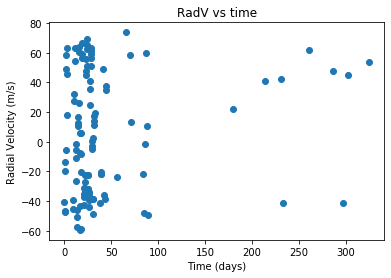

In [3]:
# Adjusted date 
t = Time - Time[0]
plt.scatter(t, Rad_vel)
plt.title('RadV vs time')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.show()

$$ t_{\mathrm{phase}} = \frac{t \bmod P}{P} $$


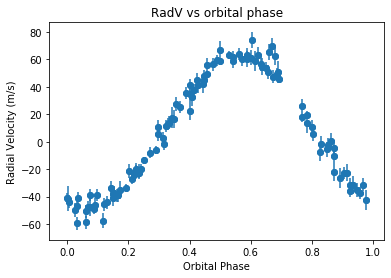

In [4]:
tphase = t%4.23/(4.23)
plt.scatter(tphase, Rad_vel)
plt.errorbar(tphase, Rad_vel, yerr= Rad_vel_error, fmt="o")
plt.xlabel('Orbital Phase')
plt.ylabel('Radial Velocity (m/s)')
plt.title('RadV vs orbital phase')
plt.show()

## 3. Defining the model that fits the data


$$ v_{\mathrm{radial}} = A \sin(B~t_{\mathrm{phase}}+C) $$


In [5]:
def vradial(tphase,A,B,C):
    vrad = A*np.sin(B*tphase + C)
    return vrad

## 4. Fitting the data with the model


In [6]:
def calculate_error(ys_actual, ys_model, sigma):
    """
    Calculate the chi-squared error between two sets of data
    """
    return ((ys_actual-ys_model)**2/(2*sigma**2)).sum()/(ys_actual.size)

$$
    f(x) = W x^2 + I
$$
$$
    P = e^{-\chi_1^2}/e^{-\chi_0^2}
$$

In [7]:
from math import e

# Total number of pointsto sample
num_sample_points = 100000

# Weighting factor for the random step
step_size = 0.1
sigma = np.mean(Rad_vel_error)

# Provide an initial guess for the width and intercept parameters

As = [60.0] # We can eyeball this one from the plot
Bs = [2.5*np.pi] # We'll choose something that will allow the walker to wander for a bit
Cs = [-0.5] # this is a guess!

As_steps = [0]
Bs_steps = [0]
Cs_steps = [0]

value1 = vradial(tphase, As[-1], Bs[-1],Cs[-1])
x2_0 = calculate_error(Rad_vel,value1,sigma)

for i in range(num_sample_points):
    A = As[-1]
    B = Bs[-1]
    C = Cs[-1]
    step_A = np.random.normal(scale=step_size)
    step_B = np.random.normal(scale=step_size)
    step_C = np.random.normal(scale=step_size)
    tmp_A = A+step_A
    tmp_B = B+step_B
    tmp_C = C+step_C
    
    value2 = vradial(tphase, tmp_A, tmp_B,tmp_C)
    x2_1 = calculate_error(Rad_vel, value2, sigma)
    
    P = (e**(-x2_1))/(e**(-x2_0))
    
    r = np.random.uniform()

    if r<P:
        As.append(tmp_A)
        Bs.append(tmp_B)
        Cs.append(tmp_C)
        A = tmp_A
        B = tmp_B
        C = tmp_C
        x2_0 = x2_1

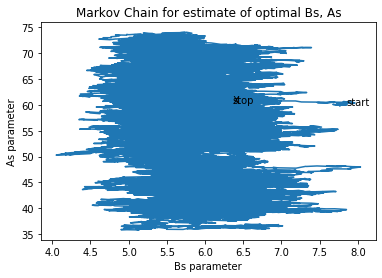

In [8]:
plt.plot(Bs,As)

plt.annotate('start', xy=(Bs[0], As[0]))
plt.annotate('stop', xy=(Bs[-1], As[-1]))
plt.annotate('X', xy=(B, A))

plt.xlabel('Bs parameter')
plt.ylabel('As parameter')
plt.title('Markov Chain for estimate of optimal Bs, As');

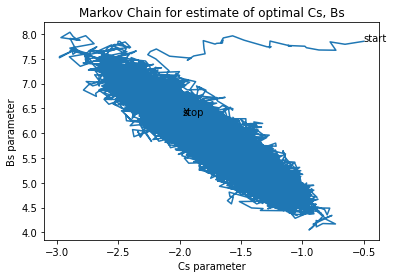

In [9]:
plt.plot(Cs,Bs)

plt.annotate('start', xy=(Cs[0], Bs[0]))
plt.annotate('stop', xy=(Cs[-1], Bs[-1]))
plt.annotate('X', xy=(C, B))

plt.xlabel('Cs parameter')
plt.ylabel('Bs parameter')
plt.title('Markov Chain for estimate of optimal Cs, Bs');

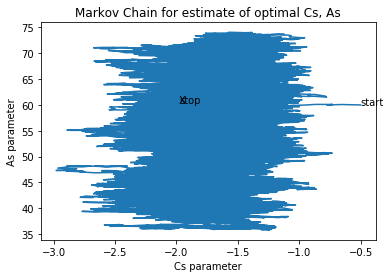

In [10]:
plt.plot(Cs,As)

plt.annotate('start', xy=(Cs[0], As[0]))
plt.annotate('stop', xy=(Cs[-1], As[-1]))
plt.annotate('X', xy=(C, A))

plt.xlabel('Cs parameter')
plt.ylabel('As parameter')
plt.title('Markov Chain for estimate of optimal Cs, As');

## 6. Finding the best fit values


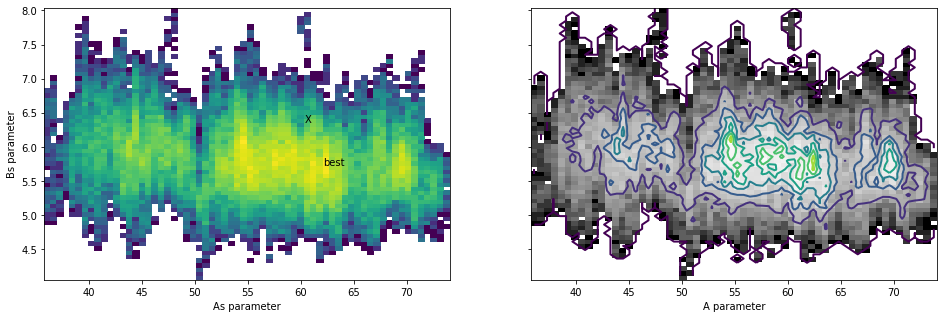

In [11]:
from matplotlib.colors import LogNorm

fig, [colored, bw] = plt.subplots(1,2, sharey=True, figsize = (16, 5))

counts, xbin, ybin, img = colored.hist2d(As, Bs, bins=64, norm=LogNorm())
colored.annotate('X', xy=(A, B))

# use np.argwhere() to find the bin(s) with the max counts
max_location = np.argwhere(counts == counts.max())

# Use the location of the max to find the best width and intercept parameters
best_A = xbin[max_location[0,0]]
best_B = ybin[max_location[0,1]]
colored.annotate('best', xy=(best_A, best_B))

bw.hist2d(As, Bs, bins=60, norm=LogNorm(), cmap='gray')
bw.contour(0.5*(xbin[1:]+xbin[:-1]), 0.5*(ybin[1:]+ybin[1:]), counts.transpose(), linewidths=2)

colored.set_xlabel("As parameter")
colored.set_ylabel("Bs parameter")
bw.set_xlabel("A parameter")
plt.show()

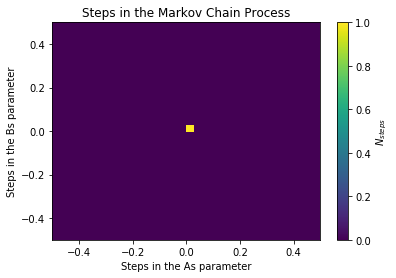

In [12]:
# 2D hist
plt.hist2d(As_steps, Bs_steps, bins=32)

plt.xlabel('Steps in the As parameter')
plt.ylabel('Steps in the Bs parameter')
plt.title('Steps in the Markov Chain Process');
cb = plt.colorbar()
cb.set_label("$N_{steps}$")

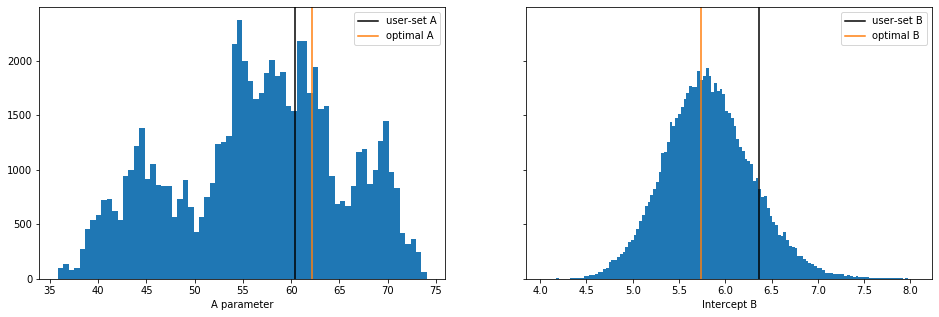

In [13]:
fig, [A_hist, B_hist] = plt.subplots(1,2, sharey=True, figsize = (16, 5))

A_hist.hist(As, bins='auto');
A_hist.set_xlabel("A parameter")
A_hist.axvline(A, color = 'black', label="user-set A")
A_hist.axvline(best_A, color = '#ff7f0e', label='optimal A')
A_hist.legend()

B_hist.hist(Bs, bins='auto');
B_hist.set_xlabel("Intercept B")
B_hist.axvline(B, color = 'black', label="user-set B")
B_hist.axvline(best_B, color = '#ff7f0e', label="optimal B")
B_hist.legend()

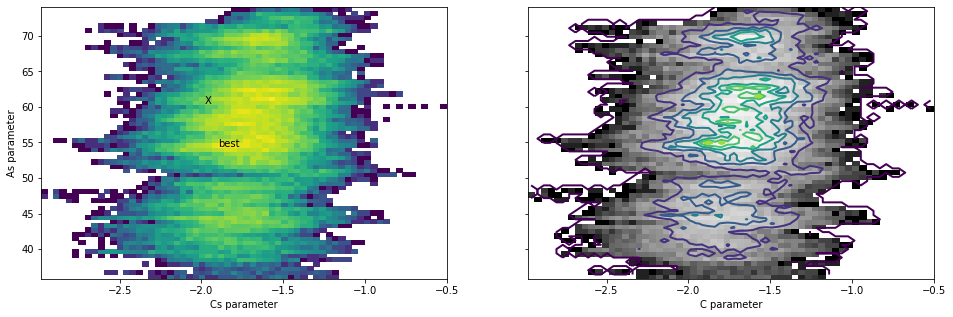

In [14]:
from matplotlib.colors import LogNorm

fig, [colored, bw] = plt.subplots(1,2, sharey=True, figsize = (16, 5))

counts, xbin, ybin, img = colored.hist2d(Cs, As, bins=64, norm=LogNorm())
colored.annotate('X', xy=(C, A))

# use np.argwhere() to find the bin(s) with the max counts
max_location = np.argwhere(counts == counts.max())

# Use the location of the max to find the best width and intercept parameters
best_C = xbin[max_location[0,0]]
best_A = ybin[max_location[0,1]]
colored.annotate('best', xy=(best_C, best_A))

bw.hist2d(Cs, As, bins=60, norm=LogNorm(), cmap='gray')
bw.contour(0.5*(xbin[1:]+xbin[:-1]), 0.5*(ybin[1:]+ybin[1:]), counts.transpose(), linewidths=2)

colored.set_xlabel("Cs parameter")
colored.set_ylabel("As parameter")
bw.set_xlabel("C parameter")
plt.show()

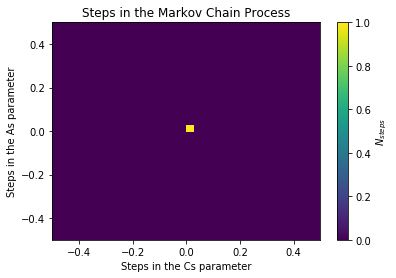

In [15]:
# 2d hist
plt.hist2d(Cs_steps, As_steps, bins=32)

plt.xlabel('Steps in the Cs parameter')
plt.ylabel('Steps in the As parameter')
plt.title('Steps in the Markov Chain Process');
cb = plt.colorbar()
cb.set_label("$N_{steps}$")

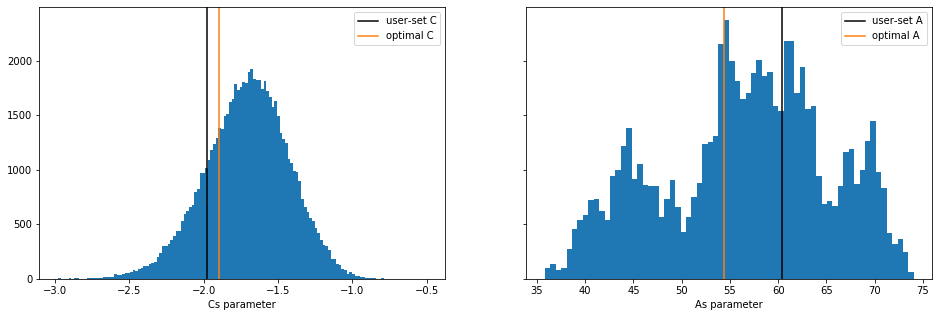

In [16]:
# 1d hist
fig, [C_hist, A_hist] = plt.subplots(1,2, sharey=True, figsize = (16, 5))

C_hist.hist(Cs, bins='auto');
C_hist.set_xlabel("Cs parameter")
C_hist.axvline(C, color = 'black', label="user-set C")
C_hist.axvline(best_C, color = '#ff7f0e', label='optimal C')
C_hist.legend()

A_hist.hist(As, bins='auto');
A_hist.set_xlabel("As parameter")
A_hist.axvline(A, color = 'black', label="user-set A")
A_hist.axvline(best_A, color = '#ff7f0e', label="optimal A")
A_hist.legend()

## 7. Comparing the best fit model to the data


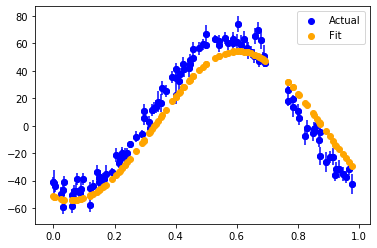

In [17]:
ys_fit = vradial(tphase, best_A, best_B, best_C)
plt.scatter(tphase, Rad_vel, label = 'Actual', color = 'blue')
plt.scatter(tphase,ys_fit, label = 'Fit', color = 'orange')
plt.errorbar(tphase, Rad_vel, yerr= Rad_vel_error, fmt="o",linewidth = None, alpha = 1, color = 'blue',zorder = 0)

plt.legend()

## 8. Understanding the physical meaning of the best fit parameters



$$ r = \big[\frac{G~M_{\star}~P^2}{4~\pi^2}\big]^{1/3} $$
$$ v_{\mathrm{planet}} = \sqrt{\frac{G~M_{\star}}{r}} $$
$$ M_{\mathrm{planet}} = \frac{M_{\star}v_{\star}}{v_{\mathrm{planet}}} $$

In [18]:
def physmeaning(A,B):
    PGuess = 4.23
    Pdays = (((2*np.pi)/B)*PGuess)*(86400)
    r = ((6.67E-11*(1.06*2E+30)*Pdays**2)/(4*np.pi**2))**(1/3)
    vp = np.sqrt((6.67E-11*1.06*2E+30)/(r))
    Mp = (1.06*2E+30*A)/(vp)
    
    return r, Mp

### Estimating the properties of the planetary system


In [19]:
radius = physmeaning(best_A,best_B)[0]
mass = physmeaning(best_A,best_B)[1]
radius_AU = radius/1.496E+11 # AU
mass_jup = mass/1.898E+27 # jupiter mass
print('The radius of the planet orbit is',radius_AU,'AU')
print('The mass of the planet is',mass_jup,'Jupiter mass units')

The radius of the planet orbit is 0.055579231319591256 AU
The mass of the planet is 0.46545916068560866 Jupiter mass units


How do the results compare to the known values for 51 Pegasi b?

The results are similar. The known values for 51 Pegasi b for semi-major axis and mass is 0.052 AU and 0.47 Jupiter mass which are very close to my found values.

## Exploring how changes to the method or the model changes the results


In [20]:
# One example of different initial conditions: step size = 0.1/100, number iterations = 100000*10,  Parameter change based off best values

# Total number of points to sample
num_sample_points = 100000*10

# Weighting factor for the random step
step_size = 0.1/100
sigma = np.mean(Rad_vel_error)

# Provide an initial guess for the width and intercept parameters

As = [55.0] # We can eyeball this one from the plot
Bs = [2.5*np.pi] # We'll choose something that will allow the walker to wander for a bit
Cs = [-0.5] # this is a guess!

As_steps = [0]
Bs_steps = [0]
Cs_steps = [0]

value1 = vradial(tphase, As[-1], Bs[-1],Cs[-1])
x2_0 = calculate_error(Rad_vel,value1,sigma)

for i in range(num_sample_points):
    A = As[-1]
    B = Bs[-1]
    C = Cs[-1]
    step_A = np.random.normal(scale=step_size)
    step_B = np.random.normal(scale=step_size)
    step_C = np.random.normal(scale=step_size)
    tmp_A = A+step_A
    tmp_B = B+step_B
    tmp_C = C+step_C
    
    value2 = vradial(tphase, tmp_A, tmp_B,tmp_C)
    x2_1 = calculate_error(Rad_vel, value2, sigma)
    
    P = (e**(-x2_1))/(e**(-x2_0))
    
    r = np.random.uniform()

    if r<P:
        As.append(tmp_A)
        Bs.append(tmp_B)
        Cs.append(tmp_C)
        A = tmp_A
        B = tmp_B
        C = tmp_C
        x2_0 = x2_1

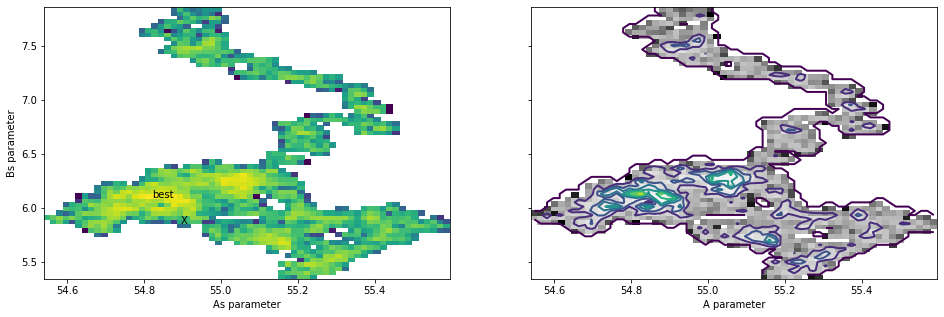

In [21]:
from matplotlib.colors import LogNorm

fig, [colored, bw] = plt.subplots(1,2, sharey=True, figsize = (16, 5))

counts, xbin, ybin, img = colored.hist2d(As, Bs, bins=64, norm=LogNorm())
colored.annotate('X', xy=(A, B))

# use np.argwhere() to find the bin(s) with the max counts
max_location = np.argwhere(counts == counts.max())

# Use the location of the max to find the best width and intercept parameters
best_A = xbin[max_location[0,0]]
best_B = ybin[max_location[0,1]]
colored.annotate('best', xy=(best_A, best_B))

bw.hist2d(As, Bs, bins=60, norm=LogNorm(), cmap='gray')
bw.contour(0.5*(xbin[1:]+xbin[:-1]), 0.5*(ybin[1:]+ybin[1:]), counts.transpose(), linewidths=2)

colored.set_xlabel("As parameter")
colored.set_ylabel("Bs parameter")
bw.set_xlabel("A parameter")
plt.show()

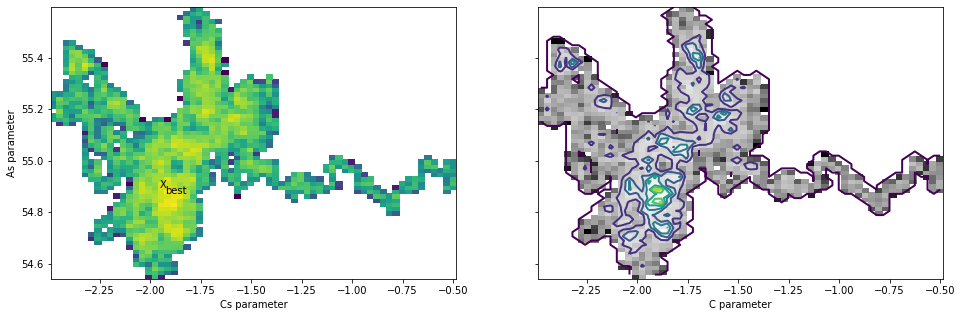

In [22]:
from matplotlib.colors import LogNorm

fig, [colored, bw] = plt.subplots(1,2, sharey=True, figsize = (16, 5))

counts, xbin, ybin, img = colored.hist2d(Cs, As, bins=64, norm=LogNorm())
colored.annotate('X', xy=(C, A))

# use np.argwhere() to find the bin(s) with the max counts
max_location = np.argwhere(counts == counts.max())

# Use the location of the max to find the best width and intercept parameters
best_C = xbin[max_location[0,0]]
best_A = ybin[max_location[0,1]]
colored.annotate('best', xy=(best_C, best_A))

bw.hist2d(Cs, As, bins=60, norm=LogNorm(), cmap='gray')
bw.contour(0.5*(xbin[1:]+xbin[:-1]), 0.5*(ybin[1:]+ybin[1:]), counts.transpose(), linewidths=2)

colored.set_xlabel("Cs parameter")
colored.set_ylabel("As parameter")
bw.set_xlabel("C parameter")
plt.show()

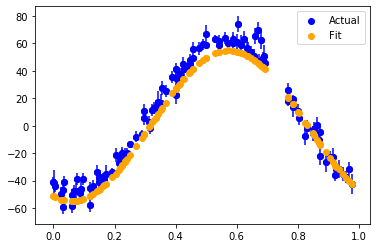

In [23]:
ys_fit = vradial(tphase, best_A, best_B, best_C)
plt.scatter(tphase, Rad_vel, label = 'Actual', color = 'blue')
plt.scatter(tphase,ys_fit, label = 'Fit', color = 'orange')
plt.errorbar(tphase, Rad_vel, yerr= Rad_vel_error, fmt="o",linewidth = None, alpha = 1, color = 'blue',zorder = 0)

plt.legend()

In [24]:
radius = physmeaning(best_A,best_B)[0]
mass = physmeaning(best_A,best_B)[1]
radius_AU = radius/1.496E+11 # AU
mass_jup = mass/1.898E+27 # jupiter mass
print('The radius of the planet orbit is',radius_AU,'AU')
print('The mass of the planet is',mass_jup,'Jupiter mass units')

The radius of the planet orbit is 0.05335729187991333 AU
The mass of the planet is 0.4604817191112544 Jupiter mass units


#### Compare:
These values are much closer to the actual values than the less accurate model.